# FIFI-LS Resampling Examples

In [1]:
# Initial imports
import glob
import numpy as np
import time
from pypeutils.resampling.resample import Resample
import matplotlib.pyplot as plt
import tempfile
import warnings

# pyredux needs to be installed
with warnings.catch_warnings():
    warnings.simplefilter("ignore", ImportError)
    from redux.sofia.fifils_reduction import FIFILSReduction
    
# pyfifi needs to be installed
from fifi_ls.resample import combine_files, get_grid_info

%matplotlib inline

## Large data tests

Load in the data:

In [2]:
files = glob.glob('/Users/dperera/test_data/fifi-ls/large/wsh/*.fits')
red = FIFILSReduction()
red.load(files)
red.load_parameters()
hduls = red.input

Load the parameters:

In [3]:
param = red.get_parameter_set()
save = param.get_value('save')
error_weighting = param.get_value('error_weighting')
xy_oversample = param.get_value('xy_oversample')
w_oversample = param.get_value('w_oversample')
xy_order = param.get_value('xy_order')
w_order = param.get_value('w_order')
xy_window = param.get_value('xy_window')
w_window = param.get_value('w_window')
xy_smoothing = param.get_value('xy_smoothing')
w_smoothing = param.get_value('w_smoothing')
fitthresh = param.get_value('fitthresh')
posthresh = param.get_value('posthresh')
negthresh = param.get_value('negthresh')
xythresh = param.get_value('xy_edge_threshold')
wthresh = param.get_value('w_edge_threshold')

order = xy_order, xy_order, w_order
edge_threshold = xythresh, xythresh, wthresh
window = xy_window, xy_window, w_window
oversample = xy_oversample, w_oversample
smoothing = xy_smoothing, xy_smoothing, w_smoothing

robust = posthresh
neg_threshold = negthresh
fit_threshold = fitthresh
edge_mode = 'edges'
fix_order = True
write = False

combined = combine_files(hduls)
grid_info = get_grid_info(combined, oversample=oversample)

fit_wdw = (window[0] * grid_info['xy_fwhm'],
           window[1] * grid_info['xy_fwhm'],
           window[2] * grid_info['wave_fwhm'])

flxvals = np.hstack([f.ravel() for f in combined['FLUX']])
errvals = np.hstack([e.ravel() for e in combined['ERROR']])

settings = {'smoothing': smoothing, 'fit_threshold': fit_threshold,
            'error_weighting': error_weighting,
            'edge_algorithm': 'com_distance',
            'edge_threshold': edge_threshold,
            'get_error': True, 'get_counts': True}


INFO: Reading 301 files [fifi_ls.resample]
INFO: Combining and rotating relative to the first file (F0317_FI_IFS_75001643_BLU_WSH_200167-200169.fits) [fifi_ls.resample]
INFO: Overall wave min/max (um): 51.705853 52.049079 [fifi_ls.resample]
INFO: Overall X min/max (arcsec): -262.795465 141.233977 [fifi_ls.resample]
INFO: Overall Y min/max (arcsec): -423.279308 16.307211 [fifi_ls.resample]
INFO: Output spectral pixel scale: 0.007205 um [fifi_ls.resample]
INFO: Average spectral FWHM: 0.057642 um [fifi_ls.resample]
INFO: Pixel size for channel: 6.223095 arcsec [fifi_ls.resample]
INFO: Average spatial FWHM for channel: 5.000000 arcsec [fifi_ls.resample]
INFO: Output spatial pixel scale: 1.000000 arcsec/pix [fifi_ls.resample]
INFO: Output grid size (nw, ny, nx): 49x441x405 [fifi_ls.resample]


Perform the resampling:

In [4]:
resampler = Resample(grid_info['coordinates'].copy(), flxvals, error=errvals,
                     fix_order=fix_order, window=fit_wdw, order=order, robust=robust,
                     negthresh=neg_threshold, mode=edge_mode)

Perform a serial reduction:

In [5]:
tstart_serial = time.time()
fluxs, stds, counts = resampler(*grid_info['grid'], **settings)
tstop_serial = time.time()
print("Completed in %s seconds" % (tstop_serial - tstart_serial))

Completed in 274.32647013664246 seconds


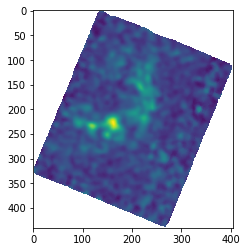

In [6]:
plt.imshow(fluxs[21])

Now attempt a parallel reduction using joblib:

In [7]:
# This is great for laptops or small sets of data
import psutil

# For smaller sets a large number of cores is fantastic,
# but half the number for this large set seems best.
# Using all cores on large data is slower than serial.
njobs = psutil.cpu_count() // 2
print("Using %i jobs" % njobs)

if njobs in [0, 1]:
    tstart_joblib = tstart_serial
    tstop_joblib = tstop_serial
    fluxj, stdj, countj = fluxs, stds, counts
    print("Would default to serial reduction... cancelling")
else:
    tstart_joblib = time.time()
    fluxj, stdj, countj = resampler(*grid_info['grid'], jobs=njobs, **settings)
    tstop_joblib = time.time()
print("Completed in %s seconds" % (tstop_joblib - tstart_joblib))

Using 4 jobs
Completed in 125.45053696632385 seconds


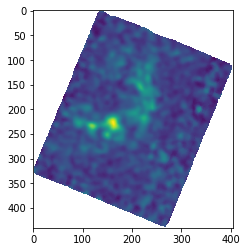

In [8]:
plt.imshow(fluxj[21])

Now attempt a parallel reduction using dask:

In [9]:
# dask seems to be great for large data on systems with a
# large amount of memory and cores.  Joblib is better otherwise.

# Indicate dask should be used by setting client to a dict or
# an existing dask.distributed.Client:

# client={}  # Setting memory_limit on my workstation fails
client = {'memory_limit': '12GB'}  # Not setting memory_limit on laptop fails

# NOTE: You may need to use client = {'memory_limit': '12GB'} or
# something to get it to work, this really depends on your system.
# See other worker and client keyword arguments in dask if you're
# having difficulty.

tstart_dask = time.time()
fluxd, stdd, countd = resampler(*grid_info['grid'], client=client, **settings)
tstop_dask = time.time()
print("Completed in %s seconds" % (tstop_dask - tstart_dask))

Completed in 182.93115210533142 seconds


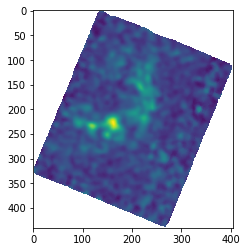

In [10]:
plt.imshow(fluxd[21])

In [11]:
tserial = tstop_serial - tstart_serial
tjoblib = tstop_joblib - tstart_joblib
tdask = tstop_dask - tstart_dask

print("Serial: %s seconds" % tserial)
print("Joblib: %s seconds" % tjoblib)
print("Dask: %s seconds" % tdask)
print('')

dask_factor = tserial / tdask
joblib_factor = tserial / tjoblib

print("Joblib is %s times faster than serial" % joblib_factor)
print("Dask is %s times faster than serial" % dask_factor)

assert np.allclose(fluxs, fluxj, equal_nan=True)
assert np.allclose(stds, stdj, equal_nan=True)
assert np.allclose(counts, countj, equal_nan=True)
assert np.allclose(fluxs, fluxd, equal_nan=True)
assert np.allclose(stds, stdd, equal_nan=True)
assert np.allclose(counts, countd, equal_nan=True)

# If we got here:
print('\nW' + 'O' * 5 + 'H' + 'O'* 10 + '!' * 20)

Serial: 274.32647013664246 seconds
Joblib: 125.45053696632385 seconds
Dask: 182.93115210533142 seconds

Joblib is 2.1867301389892266 times faster than serial
Dask is 1.4996159318927034 times faster than serial

WOOOOOHOOOOOOOOOO!!!!!!!!!!!!!!!!!!!!
